# Assignment 1

Tasks:

- Train and Evaluate an MLP Classifier on the SVHN dataset using PyTorch
- Draw learning curves (train/eval loss, train/eval classification accuracy) and confusion matrix
- Visualize some images, along with the predictions from the model
- Use *Optuna* to optimize (at least) two hyper-parameters (e.g, number of layers or hidden dimension) and show me some nice optimization plots :) 
  What parameters seem more important? What values are reasonable?
- Visualize some statistics (e.g., norm, max, mean, ...) of the gradients for some parameters during training. How do these change?
- **Extra Point**:
  - Train and evaluate a shallow MLP-Mixer model: https://openreview.net/pdf?id=EI2KOXKdnP
  - Compare it with the best MLP model from before
  - Does it work better? Why or why not?

Contents:

- [x] Setup
- [x] Data
    - [x] Preparing the SVHN dataset
    - [x] Visualization of images
- [x] Model
    - [x] Building the MLP model
    - [x] Writing a summary or something
- [x] Training and evaluation of an MLP Classifier
    - [x] Training and evaluation
    - [x] Visualization of predictions
    - [x] Visualization of performance
        - [x] Loss plots
        - [x] Classification accuracy plots
        - [x] Confusion matrix
    - [x] Visualization of statistics of the gradients for some parameters during training
- [x] Hyperparameter optimization
    - [x] Optimizing at least two hyperparameters, e.g, number of layers or hidden dimension
    - [x] Visualization of optimization, discussion
- [ ] **Extra Point**
    - [ ] Train and evaluate a shallow [MLP-Mixer](https://openreview.net/pdf?id=EI2KOXKdnP) model
    - [ ] Compare it with the best MLP model from before. Does it work better? Why or why not?

## Setup

### Modules

In [1]:
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sbn
import sklearn.metrics as skl_metrics
import torch
import torchsummary
import torchvision as tv
from tqdm import tqdm

### Paths

In [2]:
PATH_CWD = "."
DIR_DATA = "data"
DIR_DATASET = "svhn"
DIR_EXPERIMENTS = "experiments"
NAME_EXPERIMENT = "mlp_svhn"

path_cwd = Path(PATH_CWD)
path_dir_dataset = path_cwd / DIR_DATA / DIR_DATASET
path_dir_experiment = path_cwd / DIR_EXPERIMENTS / NAME_EXPERIMENT

In [3]:
path_dir_experiment.mkdir(parents=True, exist_ok=True)

print(f"Experiment path: {path_dir_experiment}")

Experiment path: experiments/mlp_svhn


### Config

In [4]:
BATCHSIZE = 1024
SHUFFLE_TRAIN = True
SHUFFLE_TEST = False
NUM_WORKERS_DATALOADING = 2
NUM_EPOCHS = 100
LR = 1e-3
DIMS_HIDDEN = [512]
LAYER_NORM = torch.nn.BatchNorm1d
LAYER_ACTIVATION = torch.nn.ReLU
USE_BIAS = True
PROB_DROPOUT = 0.2
# Includes softmax
CRITERION = torch.nn.CrossEntropyLoss
OPTIMIZER = torch.optim.Adam
FREQUENCY_CHECKPOINTS = 40
FREQUENCY_LOG = 10
METRICS = ["accuracy"]

## Data

### Preparing the SVHN dataset

In [5]:
def setup_data():
    dataset_train = tv.datasets.SVHN(root=path_dir_dataset, split="train", transform=tv.transforms.ToTensor(), download=True)
    dataset_test = tv.datasets.SVHN(root=path_dir_dataset, split="test", transform=tv.transforms.ToTensor(), download=True)

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCHSIZE, shuffle=SHUFFLE_TRAIN, num_workers=NUM_WORKERS_DATALOADING)
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCHSIZE, shuffle=SHUFFLE_TEST, num_workers=NUM_WORKERS_DATALOADING)

    return dataset_train, dataset_test, dataloader_train, dataloader_test

In [6]:
dataset_train, dataset_test, dataloader_train, dataloader_test = setup_data()

print("Training dataset")
print(f"    {"Length":<10}: {len(dataset_train)}")
print(f"    {"Batches":<10}: {len(dataloader_train)}")
print("Test dataset")
print(f"    {"Length":<10}: {len(dataset_test)}")
print(f"    {"Batches":<10}: {len(dataloader_test)}")

Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training dataset
    Length    : 73257
    Batches   : 72
Test dataset
    Length    : 26032
    Batches   : 26


### Visualization of images

In [7]:
def sample(dataset, indices):
    """Sample indexed items from dataset by converting list of tuples of k elements into k separate lists."""
    lists = map(list, zip(*[dataset[i] for i in indices]))
    return lists

In [8]:
num_samples = 17
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, list_labels = sample(dataset_train, indices)
images = torch.stack(list_images)
labels = torch.as_tensor(list_labels)

print(f"Shape of dataset sample: {images.shape}")
print(f"Labels: {labels}")

Shape of dataset sample: torch.Size([17, 3, 32, 32])
Labels: tensor([8, 2, 8, 1, 5, 1, 9, 5, 0, 9, 8, 5, 7, 4, 4, 2, 1])


In [9]:
def visualize_images(images, labels=None, indices=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_image(i):
        ax = plt.gca()

        if labels is not None or indices is not None:
            title = ""
            if indices is not None:
                title += rf"#${indices[i]}$"
            if indices is not None and labels is not None:
                title += " | "
            if labels is not None:
                title += rf"label: {labels[i]}"
            ax.set_title(title, fontsize=9)
        ax.set_axis_off()

        ax.imshow(images[i])

    # Assume same shape for all images
    aspect_images = images[0].shape[1] / images[0].shape[0]
    figsize = fig.get_size_inches()
    aspect_figure = figsize[1] / figsize[0]

    num_subplots = len(images)
    num_rows = max(int(np.sqrt(num_subplots) * aspect_figure / aspect_images), 1)
    num_cols = np.ceil(num_subplots / num_rows).astype(int)
    for i in range(num_subplots):
        fig.add_subplot(num_rows, num_cols, i + 1)
        subplot_image(i)

    plt.tight_layout()
    plt.show()

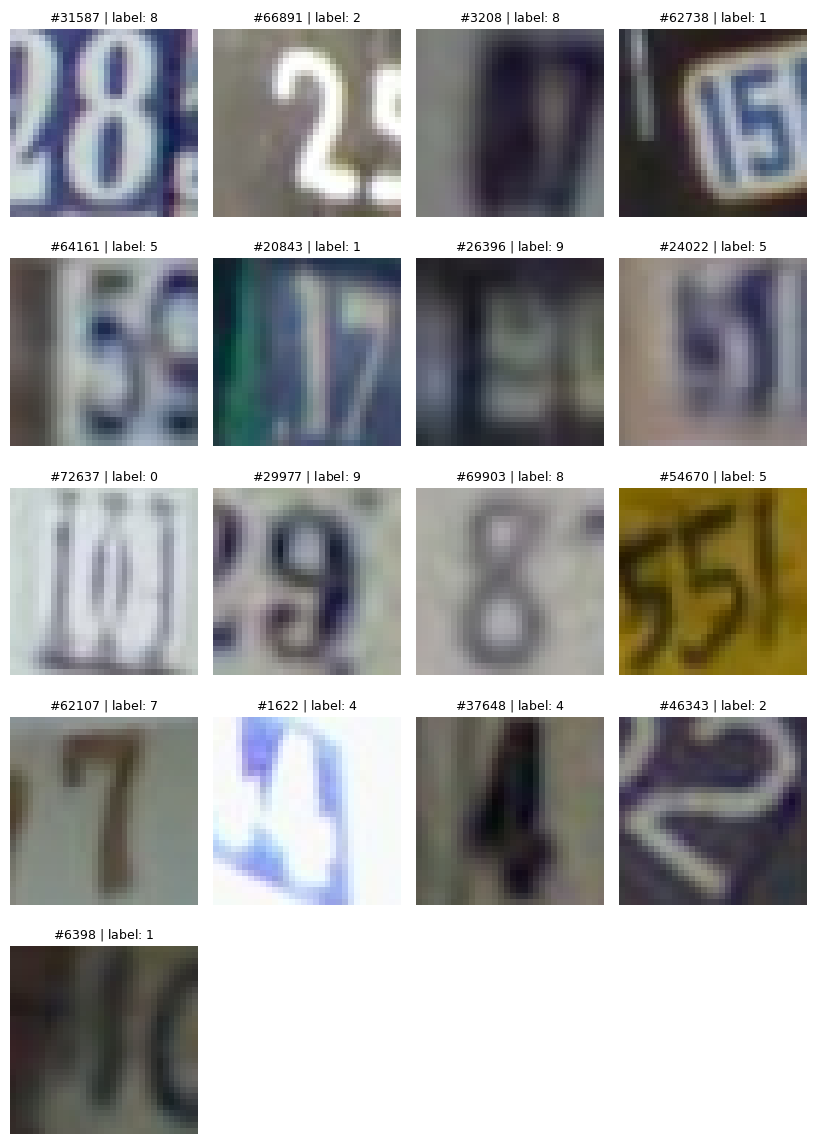

In [10]:
visualize_images(images.permute(0, 2, 3, 1), labels=labels, indices=indices)

## Model

### Building the MLP model

In [11]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        dim_input,
        dims_hidden,
        dim_output,
        layer_norm=None,
        layer_activation=torch.nn.ReLU,
        inplace=None,
        bias=True,
        dropout=None,
    ):
        super().__init__()

        kwargs_inplace = {} if inplace is None else {"inplace": inplace}
        dims = [dim_input] + dims_hidden + [dim_output]

        list_layers = []
        for dim_in, dim_out in zip(dims[:-2], dims[1:-1]):
            list_layers.append(torch.nn.Linear(dim_in, dim_out, bias=bias))
            if layer_norm is not None:
                list_layers.append(layer_norm(dim_out))
            list_layers.append(layer_activation(**kwargs_inplace))
            if dropout is not None:
                list_layers.append(torch.nn.Dropout(dropout, **kwargs_inplace))
        list_layers.append(torch.nn.Linear(dims[-2], dims[-1], bias=bias))

        self.layers = torch.nn.Sequential(*list_layers)

    def forward(self, x):
        prediction = self.layers(x)
        return prediction

In [12]:
dim_input = np.prod(np.asarray(dataset_train.data.shape[1:]))
labelset = np.unique(dataset_test.labels)

model = MLP(
    dim_input=dim_input,
    dims_hidden=DIMS_HIDDEN,
    dim_output=labelset.size,
    layer_norm=LAYER_NORM,
    layer_activation=LAYER_ACTIVATION,
    bias=USE_BIAS,
    dropout=PROB_DROPOUT,
)

print(model)

# torchsummary.summary(model.cuda(), (labelset.size, DIMS_HIDDEN[0], dataset_train.data.shape[1:]))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
def count_model_params(model):
    """Counting the number of learnable parameters in a torch.nn.Module"""
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [14]:
num_params = count_model_params(model)

print(f"Number of parameters: {num_params}")

Number of parameters: 1579530


## Training and evaluation of an MLP Classifier

### Training and evaluation

In [15]:
def save_checkpoint(path_dir_experiment, epoch, model, optimizer, name=None):
    path_dir_checkpoints = path_dir_experiment / "checkpoints"
    path_dir_checkpoints.mkdir(parents=True, exist_ok=True)

    filename = f"{name}.pth" if name is not None else f"epoch_{epoch}.pth"
    path_checkpoint = path_dir_checkpoints / filename
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path_checkpoint,
    )

In [16]:
def load_checkpoint(path, class_model):
    model = class_model()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = CRITERION()
    optimizer = OPTIMIZER(model.parameters(), lr=LR)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]

    return epoch, model, criterion, optimizer

In [17]:
def accuracy(output, targets):
    predictions = torch.argmax(output, dim=-1)
    num_correct = len(torch.where(predictions == targets)[0])
    accuracy = num_correct / len(targets)
    return accuracy

In [18]:
def train_epoch(epoch, model, device, dataloader, criterion, optimizer, bag_gradient_stats=None, quiet=False):
    progress_bar = tqdm(dataloader_train, total=len(dataloader), disable=quiet)
    losses = []
    metricss = []
    for i, (features, targets) in enumerate(progress_bar):
        features = features.to(device)
        targets = targets.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        loss = criterion(output, targets)
        losses += [loss.item()]

        metrics = dict.fromkeys(METRICS, 0.0)
        for metric in METRICS:
            metrics[metric] = eval(metric)(output, targets)
        metricss += [metrics]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if bag_gradient_stats is not None:
            for name, parameter in model.named_parameters():
                if not parameter.requires_grad:
                    continue
                for function_stats in bag_gradient_stats["functions_stats"]:
                    bag_gradient_stats["stats"][function_stats][name] += [eval(function_stats)(parameter.grad).item()]

        if i % FREQUENCY_LOG == 0 and not quiet:
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:04d} | Loss {loss.item():.5f}")

    return losses, metricss, bag_gradient_stats

In [19]:
@torch.no_grad()
def evaluate_epoch(epoch, model, device, dataloader, criterion, quiet=False):
    progress_bar = tqdm(dataloader, total=len(dataloader), disable=quiet)
    loss_unnormalized = 0.0
    metrics_unnormalized = dict.fromkeys(METRICS, 0.0)
    for i, (features, targets) in enumerate(progress_bar):
        features = features.to(device)
        targets = targets.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        loss = criterion(output, targets)
        loss_unnormalized += loss.item() * len(targets)

        for metric in METRICS:
            metrics_unnormalized[metric] += eval(metric)(output, targets) * len(targets)

        if i % FREQUENCY_LOG == 0 and not quiet:
            progress_bar.set_description(f"Evaluation: Epoch {epoch:03d} | Batch {i:04d} | Loss {loss.item():.5f}")

    loss = loss_unnormalized / len(dataloader_test.dataset)
    metrics = {}
    for key, value in metrics_unnormalized.items():
        metrics[key] = value / len(dataloader_test.dataset)
    return loss, metrics

In [20]:
def training_loop(model, device, dataloader_train, dataloader_test, path_dir_experiment, bag_gradient_stats=None, num_epochs=None, quiet=False):
    criterion = CRITERION()
    optimizer = OPTIMIZER(model.parameters(), lr=LR)

    losses_train = []
    losses_test = []
    metricss_train = []
    metricss_test = []

    model.eval()
    loss_test_epoch, metrics_test_epoch = evaluate_epoch(0, model, device, dataloader_test, criterion, quiet=quiet)
    losses_test += [loss_test_epoch]
    metricss_test += [metrics_test_epoch]

    num_epochs = num_epochs or NUM_EPOCHS
    for epoch in range(1, num_epochs + 1):
        model.train()
        losses_train_epoch, metricss_train_epoch, bag_gradient_stats = train_epoch(
            epoch,
            model,
            device,
            dataloader_train,
            criterion,
            optimizer,
            bag_gradient_stats=bag_gradient_stats,
            quiet=quiet,
        )
        losses_train += losses_train_epoch
        metricss_train += metricss_train_epoch

        save_checkpoint(path_dir_experiment, epoch, model, optimizer, name="latest")
        if epoch % FREQUENCY_CHECKPOINTS == 1 and epoch != 1:
            print("Saving model checkpoint")
            save_checkpoint(path_dir_experiment, epoch, model, optimizer)

        model.eval()
        loss_test_epoch, metrics_test_epoch = evaluate_epoch(epoch, model, device, dataloader_test, criterion, quiet=quiet)
        losses_test += [loss_test_epoch]
        metricss_test += [metrics_test_epoch]

    print("Training finished")
    save_checkpoint(path_dir_experiment, epoch, model, optimizer, name="final")
    return losses_train, losses_test, metricss_train, metricss_test, model, bag_gradient_stats

In [21]:
bag_gradient_stats = {
    "functions_stats": [
        "torch.min",
        "torch.max",
        "torch.mean",
        "torch.var",
        "torch.norm",
    ],
    "stats": {
        "torch.min": collections.defaultdict(list),
        "torch.max": collections.defaultdict(list),
        "torch.mean": collections.defaultdict(list),
        "torch.var": collections.defaultdict(list),
        "torch.norm": collections.defaultdict(list),
    },
}

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

losses_train, losses_test, metricss_train, metricss_test, model_trained, bag_gradient_stats = training_loop(
    model,
    device,
    dataloader_train,
    dataloader_test,
    path_dir_experiment,
    bag_gradient_stats=bag_gradient_stats,
)

Evaluation: Epoch 000 | Batch 0020 | Loss 2.31009: 100%|██████████| 26/26 [00:01<00:00, 18.71it/s]
Training: Epoch 001 | Batch 0070 | Loss 1.38215: 100%|██████████| 72/72 [00:03<00:00, 19.96it/s]
Evaluation: Epoch 001 | Batch 0020 | Loss 1.48758: 100%|██████████| 26/26 [00:01<00:00, 19.11it/s]
Training: Epoch 002 | Batch 0070 | Loss 1.09001: 100%|██████████| 72/72 [00:03<00:00, 20.03it/s]
Evaluation: Epoch 002 | Batch 0020 | Loss 1.39587: 100%|██████████| 26/26 [00:01<00:00, 19.62it/s]
Training: Epoch 003 | Batch 0070 | Loss 1.00652: 100%|██████████| 72/72 [00:03<00:00, 19.89it/s]
Evaluation: Epoch 003 | Batch 0020 | Loss 1.46565: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s]
Training: Epoch 004 | Batch 0070 | Loss 0.77414: 100%|██████████| 72/72 [00:03<00:00, 20.13it/s]
Evaluation: Epoch 004 | Batch 0020 | Loss 1.22877: 100%|██████████| 26/26 [00:01<00:00, 18.07it/s]
Training: Epoch 005 | Batch 0070 | Loss 0.67640: 100%|██████████| 72/72 [00:03<00:00, 20.29it/s]
Evaluation: Epoch 00

Saving model checkpoint


Evaluation: Epoch 041 | Batch 0020 | Loss 0.70413: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s]
Training: Epoch 042 | Batch 0070 | Loss 0.40619: 100%|██████████| 72/72 [00:03<00:00, 20.07it/s]
Evaluation: Epoch 042 | Batch 0020 | Loss 0.92941: 100%|██████████| 26/26 [00:01<00:00, 18.23it/s]
Training: Epoch 043 | Batch 0070 | Loss 0.37965: 100%|██████████| 72/72 [00:03<00:00, 20.02it/s]
Evaluation: Epoch 043 | Batch 0020 | Loss 0.83082: 100%|██████████| 26/26 [00:01<00:00, 18.86it/s]
Training: Epoch 044 | Batch 0070 | Loss 0.38363: 100%|██████████| 72/72 [00:03<00:00, 19.14it/s]
Evaluation: Epoch 044 | Batch 0020 | Loss 0.90283: 100%|██████████| 26/26 [00:01<00:00, 18.15it/s]
Training: Epoch 045 | Batch 0070 | Loss 0.42603: 100%|██████████| 72/72 [00:03<00:00, 20.24it/s]
Evaluation: Epoch 045 | Batch 0020 | Loss 0.81716: 100%|██████████| 26/26 [00:01<00:00, 19.60it/s]
Training: Epoch 046 | Batch 0070 | Loss 0.35628: 100%|██████████| 72/72 [00:03<00:00, 20.39it/s]
Evaluation: Epoch 04

Saving model checkpoint


Evaluation: Epoch 081 | Batch 0020 | Loss 1.34458: 100%|██████████| 26/26 [00:01<00:00, 19.64it/s]
Training: Epoch 082 | Batch 0070 | Loss 0.31165: 100%|██████████| 72/72 [00:03<00:00, 19.83it/s]
Evaluation: Epoch 082 | Batch 0020 | Loss 0.72917: 100%|██████████| 26/26 [00:01<00:00, 18.62it/s]
Training: Epoch 083 | Batch 0070 | Loss 0.37982: 100%|██████████| 72/72 [00:03<00:00, 19.84it/s]
Evaluation: Epoch 083 | Batch 0020 | Loss 1.08546: 100%|██████████| 26/26 [00:01<00:00, 19.41it/s]
Training: Epoch 084 | Batch 0070 | Loss 0.27905: 100%|██████████| 72/72 [00:03<00:00, 19.64it/s]
Evaluation: Epoch 084 | Batch 0020 | Loss 1.26289: 100%|██████████| 26/26 [00:01<00:00, 18.90it/s]
Training: Epoch 085 | Batch 0070 | Loss 0.27438: 100%|██████████| 72/72 [00:03<00:00, 20.07it/s]
Evaluation: Epoch 085 | Batch 0020 | Loss 0.71757: 100%|██████████| 26/26 [00:01<00:00, 19.28it/s]
Training: Epoch 086 | Batch 0070 | Loss 0.31862: 100%|██████████| 72/72 [00:03<00:00, 20.50it/s]
Evaluation: Epoch 08

Training finished


### Visualization of predictions

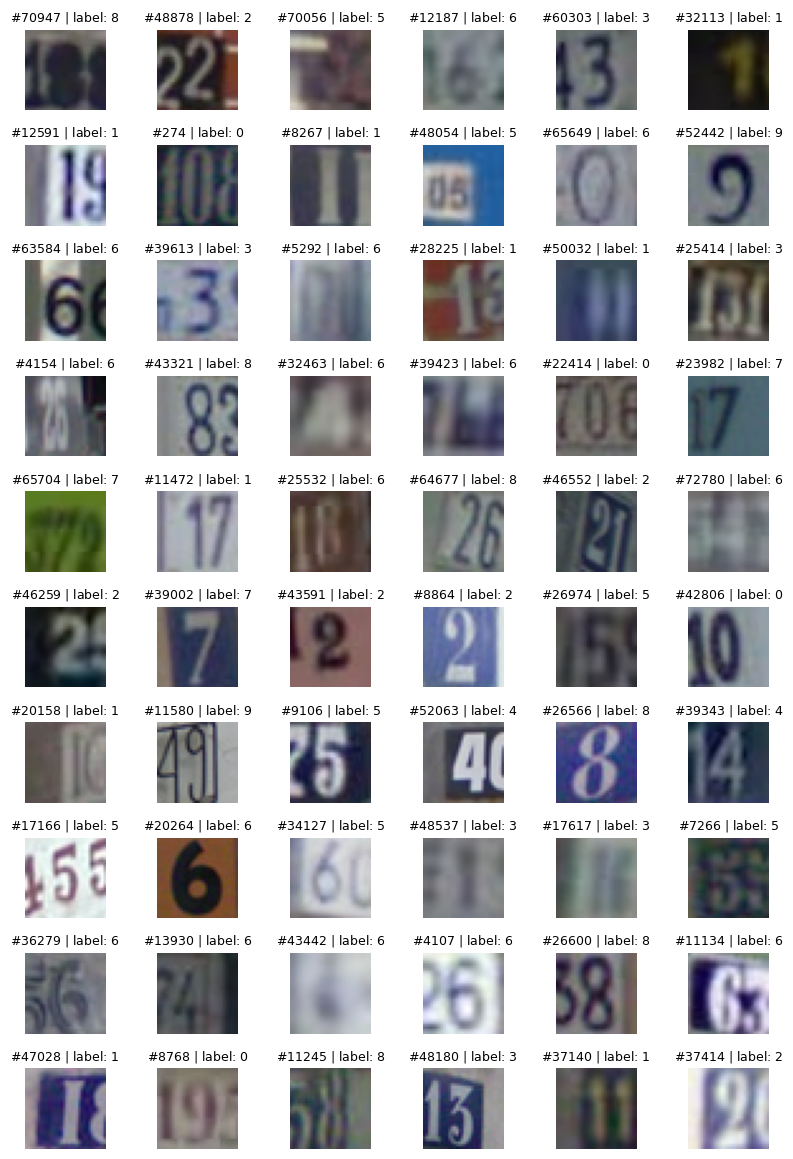

In [23]:
num_samples = 60
indices = np.random.randint(low=0, high=len(dataset_train), size=num_samples)
list_images, _ = sample(dataset_train, indices)
images = torch.stack(list_images)

images = images.to(device)
images_flat = images.flatten(start_dim=1)
output = model_trained(images_flat)
predictions = torch.argmax(output, dim=-1)

visualize_images(images.permute(0, 2, 3, 1).cpu(), labels=predictions.cpu(), indices=indices)

> From visualizing some images along with their model predictions, we can see that the training is indeed somewhat successful. Although some numbers are quite difficult to identify (for a human), the trained MLP is able to identify most of them. At a glance, indeed it seems that similar numbers like 3, 5, and 8 most often predicted with a wrong label. A deeper understanding of remaining weaknesses will be easier using e.g. a confusion matrix than this visual inspection.

### Visualization of performance

#### Loss plots

In [24]:
def iterations2epochs(iterations, batchsize, num_samples):
    """Convert array of total batch iterations to epoch scale. Also works if not the entire dataset is traversed during training."""
    num_batches = np.ceil(num_samples / batchsize).astype(int)
    samples = (iterations // num_batches) * num_samples + (iterations % num_batches) * batchsize
    batchsize_last = ((num_samples - 1) % batchsize) + 1
    samples[num_batches - 1 :: num_batches] += batchsize_last - batchsize
    epochs = samples / num_samples
    return epochs

In [25]:
def mean_per_epoch(values, batchsize, num_samples):
    """
    Get the mean per epoch from list corresponding to batch iterations.
    This functions accounts for unequal batch sizes if the last batch is smaller.
    """
    num_batches = np.ceil(num_samples / batchsize).astype(int)
    batchsize_last = ((num_samples - 1) % batchsize) + 1
    batchsizes = np.asarray([batchsize] * (num_batches - 1) + [batchsize_last])
    values_epochs = np.asarray(values).reshape(-1, num_batches)
    values_epochs = np.sum(values_epochs * batchsizes, axis=1) / num_samples
    return values_epochs

In [26]:
def smooth(f, k=5):
    """Smoothing a function using a low-pass filter (mean) of size K"""
    kernel = np.ones(k) / k
    # Account for boundaries
    f = np.concatenate([f[: int(k // 2)], f, f[int(-k // 2) :]])
    smooth_f = np.convolve(f, kernel, mode="same")
    # Remove boundary-fixes
    smooth_f = smooth_f[k // 2 : -k // 2]
    return smooth_f

In [27]:
def plot_loss(iterations_train, losses_train, losses_test, num_samples_train):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_loss(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({"logscale" if use_logscale else "linearscale"})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Cross-entropy loss", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs_iterations_train = iterations2epochs(iterations_train, BATCHSIZE, num_samples_train)
        losses_train_smoothed = smooth(losses_train, k=int(num_samples_train / (BATCHSIZE * 2)))

        ax.plot(epochs_iterations_train, losses_train, alpha=0.8, label="Loss (training)")
        ax.plot(epochs_iterations_train, losses_train_smoothed)
        ax.plot(losses_test, label="Loss (evaluation)")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_loss()

    fig.add_subplot(3, 1, 2)
    subplot_loss(use_logscale=True)

    plt.tight_layout()
    plt.show()

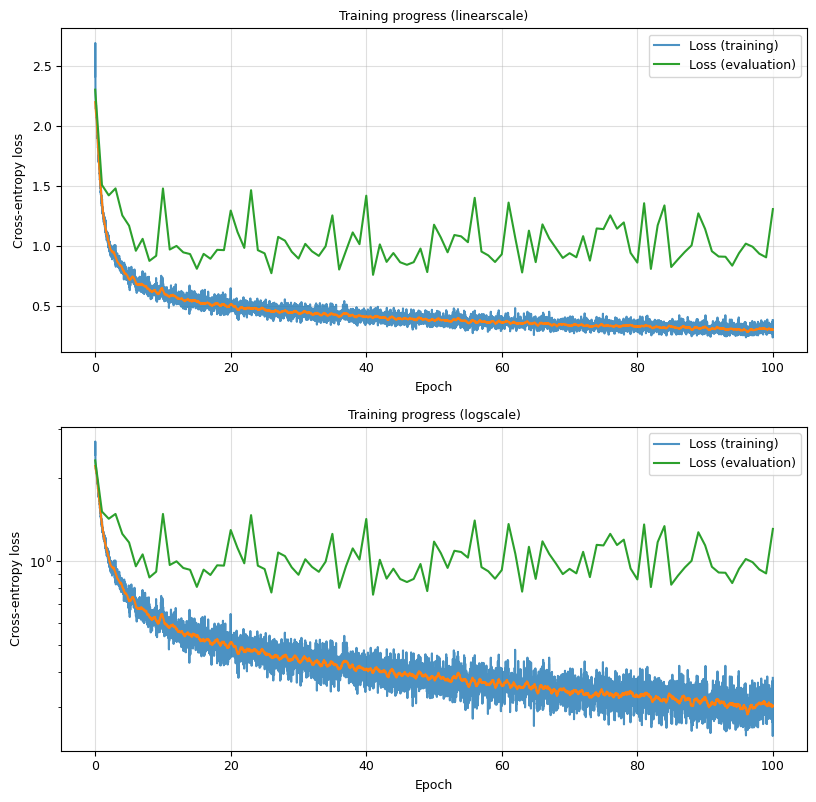

In [28]:
iterations_train = np.arange(len(losses_train), dtype=float)

plot_loss(
    iterations_train,
    losses_train,
    losses_test,
    num_samples_train=len(dataset_train),
)

> In these plots, we can see that the training does not even fully converge after $100$ epochs. Since this assignment is just for demonstrative purposes, I will leave it at that. We can already assume that there is some considerable overfitting as the evaluation loss is constant (maybe even rising) towards the end. In-between epochs, there is quite some variance which makes the curves appear so noisy. This might suggest lowering the learning rate.

#### Classification accuracy plots

In [29]:
def plot_metrics(iterations_train, metricss_train, metricss_test, num_samples_train):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_loss(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({"logscale" if use_logscale else "linearscale"})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Metric", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs = np.arange(len(losses_test))
        epochs_iterations_train = iterations2epochs(iterations_train, BATCHSIZE, num_samples_train)

        for metric in metricss_train[0].keys():
            values_metric_train = [metrics[metric] for metrics in metricss_train]
            values_metric_train_smoothed = smooth(values_metric_train, k=int(num_samples_train / (BATCHSIZE * 2)))

            ax.plot(epochs_iterations_train, values_metric_train, alpha=0.8, label=f"{metric.capitalize()} (training)")
            ax.plot(epochs_iterations_train, values_metric_train_smoothed)

        for metric in metricss_test[0].keys():
            values_metric_test = [metrics[metric] for metrics in metricss_test]
            ax.plot(epochs, values_metric_test, label=f"{metric.capitalize()} (evaluation)")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_loss()

    fig.add_subplot(3, 1, 2)
    subplot_loss(use_logscale=True)

    plt.tight_layout()
    plt.show()

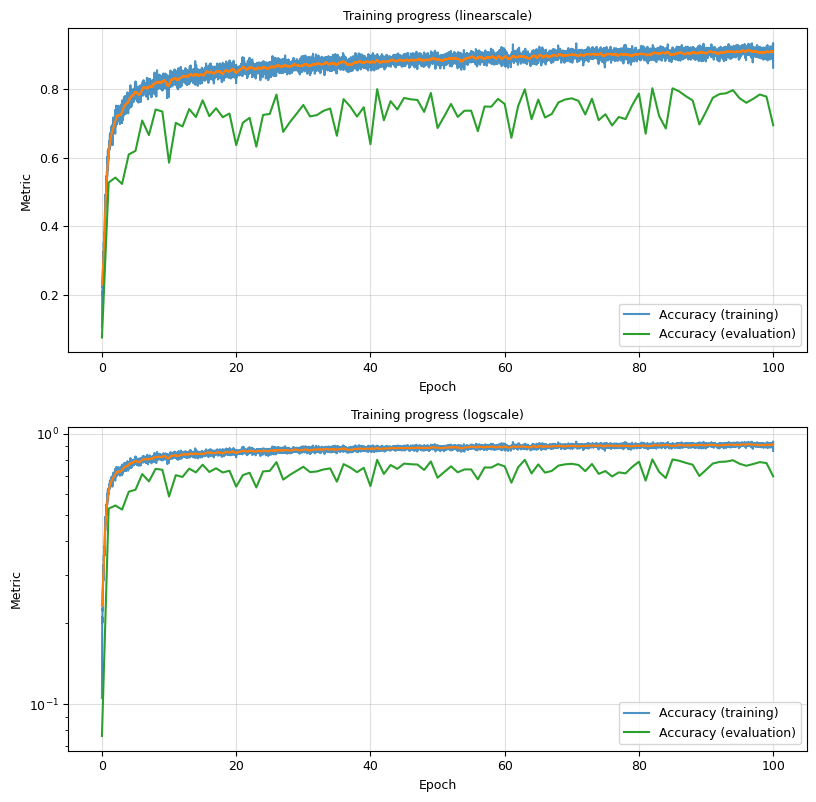

In [30]:
plot_metrics(
    iterations_train,
    metricss_train,
    metricss_test,
    num_samples_train=len(dataset_train),
)

> Again, the data is quite noisy. However, we can see that the model achieves an accuracy of almost $0.8$ using a single hidden layer and no further parameter tweaking.

#### Confusion matrix

In [31]:
def visualize_confusion(confusion, labelset):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_confusion():
        ax = plt.gca()

        confusion_normalized = confusion / np.sum(confusion, axis=1)
        df_confusion = pd.DataFrame(confusion_normalized, index=labelset, columns=labelset)

        sbn.heatmap(df_confusion, annot=True)

        ax.set_title("Confusion matrix", fontsize=9)
        ax.set_xlabel("Target", fontsize=9)
        ax.set_ylabel("Prediction", fontsize=9)
        ax.tick_params(bottom=False, left=False)

    fig.add_subplot(3, 1, 1)
    subplot_confusion()

    plt.tight_layout()
    plt.show()

In [32]:
def run_inference(model, device, dataloader):
    progress_bar = tqdm(dataloader, total=len(dataloader))
    predictions = []
    targets = []
    for i, (features, target) in enumerate(progress_bar):
        features = features.to(device)
        target = target.to(device)

        features_flat = features.flatten(start_dim=1)
        output = model(features_flat)

        predictions += [torch.argmax(output, dim=-1).item()]
        targets += [target.item()]

        if i % 10 == 0 or i == len(dataloader) - 1:
            progress_bar.set_description(f"Inference: sample {i:04d}")

    return predictions, targets

In [33]:
dataloader_inference = torch.utils.data.DataLoader(dataset_test, shuffle=SHUFFLE_TEST, num_workers=NUM_WORKERS_DATALOADING)

predictions, targets = run_inference(model_trained, device, dataloader_inference)

  0%|          | 0/26032 [00:00<?, ?it/s]

Inference: sample 26031: 100%|██████████| 26032/26032 [00:24<00:00, 1082.37it/s]


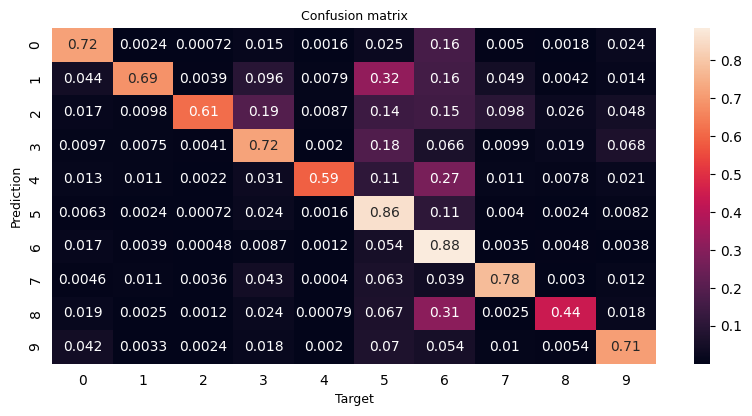

In [34]:
confusion = skl_metrics.confusion_matrix(targets, predictions)

visualize_confusion(confusion, labelset)

> In this confusion matrix, we see that some numbers are more often misidentified than others. § and 8 being hard to identify in these images seems to be in accordance to a human perspective.

### Visualization of statistics of the gradients for some parameters during training

In [35]:
print(bag_gradient_stats["stats"].keys())

dict_keys(['torch.min', 'torch.max', 'torch.mean', 'torch.var', 'torch.norm'])


In [36]:
def plot_gradient_stats(iterations_train, stats, num_samples_train):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_gradient_stat(name, stat):
        ax = plt.gca()

        ax.set_title(f"Gradient stat: {name.capitalize()}", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel(f"{name.capitalize()}", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)

        epochs_iterations_train = iterations2epochs(iterations_train, BATCHSIZE, num_samples_train)
        for name_parameter, parameter in stat.items():
            ax.plot(epochs_iterations_train, parameter, alpha=0.6, label=f"{name_parameter}")

        ax.legend(fontsize=9)

    for i, (name, stat) in enumerate(stats.items()):
        fig.add_subplot(len(stats), 1, i + 1)
        subplot_gradient_stat(name, stat)

    plt.tight_layout()
    plt.show()

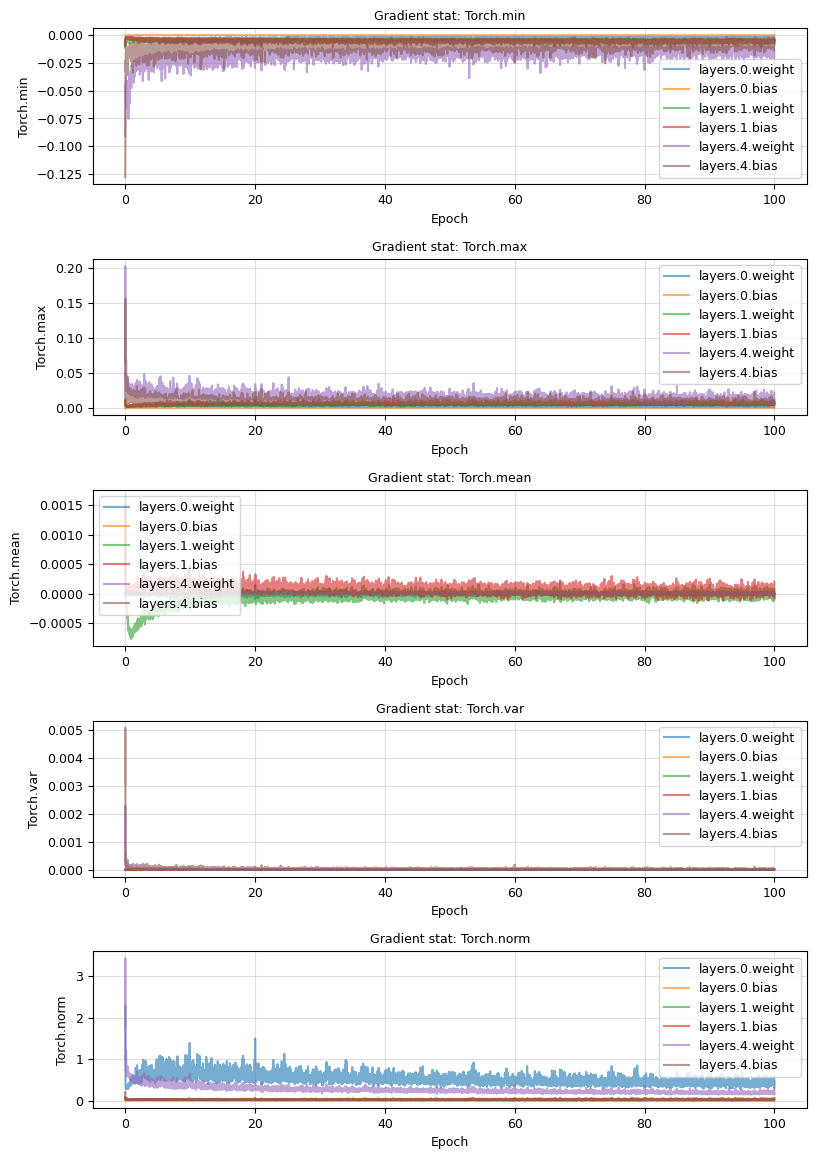

In [37]:
plot_gradient_stats(iterations_train, bag_gradient_stats["stats"], len(dataset_train))

How do these change?

> Generally, there are some more extreme values at the beginning. As the training progresses, the gradients become smaller (as we move towards a local optimum in search space) and have a smaller variance (as also visible from min and max progression). More abstract features (i.e. weights and other parameters on level deeper in the architecture) have a smaller magnitude than the earlier layer. This is likely due to the low-level input weights adapting to changing inputs, while the generalization capability actually converges.

## Hyperparameter optimization

### Optimizing at least two hyperparameters, e.g, number of layers or hidden dimension

In [41]:
def objective(trial, path_optuna, num_epochs=10):
    use_bias = trial.suggest_categorical("use_bias", [True, False])
    prob_dropout = trial.suggest_float("prob_dropout", 0.0, 0.7)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    exp_dim_hidden_first = trial.suggest_int("exp_dim_hidden_first", 6, 11)
    name_layer_activation = trial.suggest_categorical("layer_activation", ["relu", "leakyrelu", "sigmoid"])

    map_activations = {
        "relu": torch.nn.ReLU,
        "leakyrelu": torch.nn.LeakyReLU,
        "sigmoid": torch.nn.Sigmoid,
    }
    dims_hidden = [2 ** (exp_dim_hidden_first - i) for i in range(num_layers)]

    dataset_train, dataset_test, dataloader_train, dataloader_test = setup_data()

    dim_input = np.prod(np.asarray(dataset_train.data.shape[1:]))
    labelset = np.unique(dataset_test.labels)
    model = MLP(
        dim_input=dim_input,
        dims_hidden=dims_hidden,
        dim_output=labelset.size,
        layer_norm=LAYER_NORM,
        layer_activation=map_activations[name_layer_activation],
        bias=use_bias,
        dropout=prob_dropout,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    losses_train, losses_test, metricss_train, metricss_test, model_trained, bag_gradient_stats = training_loop(
        model,
        device,
        dataloader_train,
        dataloader_test,
        path_optuna,
        num_epochs=num_epochs,
        quiet=True,
    )

    metrics = np.asarray([metrics["accuracy"] for metrics in metricss_test])
    metric = np.max(metrics)
    return metric


def optuna_optimization(path_dir_experiment, num_epochs=10, num_trials=50, load_if_exists=None):
    path_db = path_dir_experiment / "optuna.db"
    if load_if_exists is False:
        path_db.unlink(missing_ok=True)

    study = optuna.create_study(
        direction="maximize",
        study_name="optuna_study",
        storage=f"sqlite:///{path_db}",
        load_if_exists=load_if_exists if load_if_exists is not None else True,
    )
    obj = lambda trial: objective(trial, path_optuna=path_dir_experiment, num_epochs=num_epochs)
    study.optimize(obj, n_trials=num_trials)
    return study

In [42]:
study = optuna_optimization(path_dir_experiment, num_trials=20)

[I 2024-05-01 23:22:18,156] Using an existing study with name 'optuna_study' instead of creating a new one.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:23:12,914] Trial 1 finished with value: 0.28438076213890595 and parameters: {'use_bias': False, 'prob_dropout': 0.36075263040005234, 'num_layers': 3, 'exp_dim_hidden_first': 9, 'layer_activation': 'sigmoid'}. Best is trial 1 with value: 0.28438076213890595.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:24:06,466] Trial 2 finished with value: 0.7098570989551322 and parameters: {'use_bias': False, 'prob_dropout': 0.01074891472654773, 'num_layers': 1, 'exp_dim_hidden_first': 6, 'layer_activation': 'relu'}. Best is trial 2 with value: 0.7098570989551322.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:25:00,085] Trial 3 finished with value: 0.29521358328211433 and parameters: {'use_bias': True, 'prob_dropout': 0.07747061516895809, 'num_layers': 1, 'exp_dim_hidden_first': 9, 'layer_activation': 'sigmoid'}. Best is trial 2 with value: 0.7098570989551322.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:25:54,300] Trial 4 finished with value: 0.7342117393976644 and parameters: {'use_bias': True, 'prob_dropout': 0.25726344257808575, 'num_layers': 1, 'exp_dim_hidden_first': 9, 'layer_activation': 'relu'}. Best is trial 4 with value: 0.7342117393976644.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:26:47,342] Trial 5 finished with value: 0.37004456054087276 and parameters: {'use_bias': False, 'prob_dropout': 0.17902783624959037, 'num_layers': 3, 'exp_dim_hidden_first': 6, 'layer_activation': 'sigmoid'}. Best is trial 4 with value: 0.7342117393976644.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:27:44,948] Trial 6 finished with value: 0.7057467732022127 and parameters: {'use_bias': False, 'prob_dropout': 0.3224987099428714, 'num_layers': 1, 'exp_dim_hidden_first': 11, 'layer_activation': 'leakyrelu'}. Best is trial 4 with value: 0.7342117393976644.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:28:40,219] Trial 7 finished with value: 0.7119314689612785 and parameters: {'use_bias': True, 'prob_dropout': 0.13101748038690972, 'num_layers': 1, 'exp_dim_hidden_first': 10, 'layer_activation': 'relu'}. Best is trial 4 with value: 0.7342117393976644.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:29:37,897] Trial 8 finished with value: 0.7252612169637369 and parameters: {'use_bias': True, 'prob_dropout': 0.18506499531502704, 'num_layers': 1, 'exp_dim_hidden_first': 11, 'layer_activation': 'leakyrelu'}. Best is trial 4 with value: 0.7342117393976644.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:30:30,652] Trial 9 finished with value: 0.22364781807006762 and parameters: {'use_bias': True, 'prob_dropout': 0.5560254446091691, 'num_layers': 1, 'exp_dim_hidden_first': 6, 'layer_activation': 'sigmoid'}. Best is trial 4 with value: 0.7342117393976644.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:31:26,703] Trial 10 finished with value: 0.7539566687154272 and parameters: {'use_bias': False, 'prob_dropout': 0.2871644492087233, 'num_layers': 3, 'exp_dim_hidden_first': 10, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:32:20,292] Trial 11 finished with value: 0.7286032575291949 and parameters: {'use_bias': False, 'prob_dropout': 0.4821248381317782, 'num_layers': 2, 'exp_dim_hidden_first': 8, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:33:14,098] Trial 12 finished with value: 0.7418561770129072 and parameters: {'use_bias': True, 'prob_dropout': 0.3148822982366159, 'num_layers': 2, 'exp_dim_hidden_first': 8, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:34:07,417] Trial 13 finished with value: 0.6712507682851875 and parameters: {'use_bias': False, 'prob_dropout': 0.6919773936852267, 'num_layers': 2, 'exp_dim_hidden_first': 8, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat


[I 2024-05-01 23:35:00,359] Trial 14 finished with value: 0.6486247695144438 and parameters: {'use_bias': True, 'prob_dropout': 0.40193603071993755, 'num_layers': 3, 'exp_dim_hidden_first': 7, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Training finished
Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:35:55,735] Trial 15 finished with value: 0.7458128457283344 and parameters: {'use_bias': True, 'prob_dropout': 0.2669352649102987, 'num_layers': 2, 'exp_dim_hidden_first': 10, 'layer_activation': 'relu'}. Best is trial 10 with value: 0.7539566687154272.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:36:51,024] Trial 16 finished with value: 0.785341118623233 and parameters: {'use_bias': False, 'prob_dropout': 0.24300245177002297, 'num_layers': 3, 'exp_dim_hidden_first': 10, 'layer_activation': 'relu'}. Best is trial 16 with value: 0.785341118623233.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:37:46,323] Trial 17 finished with value: 0.7307544560540873 and parameters: {'use_bias': False, 'prob_dropout': 0.4512245122058607, 'num_layers': 3, 'exp_dim_hidden_first': 10, 'layer_activation': 'leakyrelu'}. Best is trial 16 with value: 0.785341118623233.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:38:45,554] Trial 18 finished with value: 0.7675553165334973 and parameters: {'use_bias': False, 'prob_dropout': 0.22822065191412916, 'num_layers': 3, 'exp_dim_hidden_first': 11, 'layer_activation': 'relu'}. Best is trial 16 with value: 0.785341118623233.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:39:45,049] Trial 19 finished with value: 0.7530347264904733 and parameters: {'use_bias': False, 'prob_dropout': 0.18418659307978086, 'num_layers': 3, 'exp_dim_hidden_first': 11, 'layer_activation': 'relu'}. Best is trial 16 with value: 0.785341118623233.


Using downloaded and verified file: data/svhn/train_32x32.mat
Using downloaded and verified file: data/svhn/test_32x32.mat
Training finished


[I 2024-05-01 23:40:44,286] Trial 20 finished with value: 0.7148125384142594 and parameters: {'use_bias': False, 'prob_dropout': 0.0873287780453974, 'num_layers': 2, 'exp_dim_hidden_first': 11, 'layer_activation': 'leakyrelu'}. Best is trial 16 with value: 0.785341118623233.


### Visualization of optimization

In [ ]:
parameters_best = study.best_params
value_best = study.best_value

print(f"Best accuracy: {value_best}")
print(f"Best parameters")
for parameter, value in parameters_best.items():
    print(f"    {parameter:<10}: {value}")

Best accuracy: 0.1958743085433313
Best parameters
    use_bias  : True
    prob_dropout: 0.5784702247635486
    num_layers: 3
    exp_dim_hidden_first: 7
    layer_activation: sigmoid


In [43]:
fig = optuna.visualization.plot_timeline(study)
fig.show()

/tmp/ipykernel_2741917/2903521836.py:1: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  fig = optuna.visualization.plot_timeline(study)


In [45]:
fig = optuna.visualization.plot_contour(study, params=["exp_dim_hidden_first", "num_layers"])
fig.show()

In [48]:
fig = optuna.visualization.plot_contour(study, params=["exp_dim_hidden_first", "layer_activation"])
fig.show()

In [46]:
fig = optuna.visualization.plot_edf(study)
fig.show()

In [47]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [49]:
fig = optuna.visualization.plot_slice(study, params=["num_layers"], target_name="Accuracy")
fig.show()

What parameters seem more important?

> According to optuna, the activation layer type is most important of the considered parameters and ranges. This is likely due to the Sigmoid function performing worst by some large margin, so the optimization focuses this effect. ReLu and leaky ReLu perform similarly well. Also, the dimensionality of the hidden layers is important. Surprisingly, adding additional layers seems to have no significant beneficial effect. As any non-linear function can already be approximated with only a single hidden layer, this might indicate that adding layers actually slows down the initial learning in the first 10 epochs.

What values are reasonable?

> The results from the optuna study indicate that the highest considered dimensionality of the hidden layer (2**11 achieved the best results). However, increasing the number of layers did not show a positive effect.

> The hyperparameter optimization achieved quite some improvement of the initial settings (keeping in mind that it always runs for just 10 epochs). Using these optimized hyperparameters one could do a complete training for more than the 10 epochs in the optuna studies, and likely one will end up with an improved performance. If I should always try to maximize performance (rather than knowledge and insight), let me know. Right now, I'm prioritizing writing reusable code and trying to create a template framework for these assignment. For the first sheet, I was not yet able to finish it, and use it. Therefore, I'll stop here for now :)